#Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


#Fetch the latest data from BIG QUERY 

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
sql = '''WITH buy AS(
    SELECT
        ODMCUSID AS MemberId
        ,Count(Distinct ODDORDID) AS Otimes
        ,COUNT(DISTINCT PROD_ID) AS countBuyProduct
        ,COUNT(distinct (CASE WHEN Date(OrderDtm) <= '2020-9-30' THEN ODDORDID ELSE NULL END)) AS Ord_20SS
        ,COUNT(distinct (CASE WHEN Date(OrderDtm) > '2020-9-30'  AND Date(OrderDtm) <= '2021-3-31' THEN ODDORDID ELSE Null END)) AS Ord_20AW
        ,COUNT(distinct (CASE WHEN Date(OrderDtm) > '2021-3-31' THEN ODDORDID ELSE Null END)) AS Ord_21SS
        ,SUM(SKU_SUM_AFTER_COUPON) AS Ttl_Ord
        ,ROUND(SUM(SKU_SUM_AFTER_COUPON) / Count(Distinct ODDORDID)) AS AOV
        ,s.GENDER
        ,AGE
        ,COUNT(CASE WHEN CAT_0 = "MEN" THEN CAT_0 ELSE NULL END) AS MEN_count
        ,COUNT(CASE WHEN CAT_0 = "WOMEN" THEN CAT_0 ELSE NULL END) AS WOMEN_count
        ,STRING_AGG( DISTINCT BRAND_NAME) AS Brand_array
        ,SUM(Elegant) AS Elegant
        ,SUM(Modern) AS Modern
        ,SUM(Minimal) AS Minimal
        ,SUM(tag.Natural) AS _Natural
        ,SUM(Girly) AS Girly
        ,SUM(Vacation) AS Vacation
        ,SUM(Vintage) AS Vintage
        ,SUM(Rock) AS ROCK
        ,SUM(Outdoor) AS Outdoor
        ,SUM(Street) AS Street
        ,SUM(Mode) AS Mode
        ,SUM(Gentle) AS Gentle	
        ,SUM(Preppie) AS Preppie
        ,SUM(Artsy) AS Artsy
    FROM
        `pchome-mitch-ga-rawdata.ANALYSIS.order_product_analysis` AS s
        INNER JOIN `pchome-mitch-ga-rawdata.ANALYSIS.Cleaned_OrderId` AS t ON t.CL_ord  = s.ODDORDID
        LEFT JOIN `pchome-mitch-ga-rawdata.ANALYSIS.brand_tag` As tag on tag.BrandName = s.BRAND_NAME AND tag.Gender = s.CAT_0
    WHERE
        REFUND_STATUS IS NULL 
        AND Transfer_Status = '轉單'
        AND MARKET_PRICE > 0
        --AND DATE(ORDERDTM) >= '2020-10-01'
        AND BRAND_NAME NOT IN ('POCO','DYNABOOK','realme','Logitech','ROG')
    GROUP BY
        MemberId,
        GENDER,
        AGE
),

flat AS (
    SELECT
        visitStartTime,
        hits.page.pagePath,
        (SELECT value FROM UNNEST(hits.customDimensions) where index = 4) AS Member_Id, --AS hit_customDimension4 
    REGEXP_EXTRACT(hits.page.pagePath, 'PS.{11}') AS PROD_ID 
    FROM
    `pchome-mitch-ga-rawdata.210665845.ga_sessions_*` AS t,
    UNNEST(hits) AS hits 
    WHERE
    (_table_suffix BETWEEN '20201003' AND '20210831')
),

view AS(
    SELECT 
        Member_Id
        ,visitStartTime
        ,PROD_ID 
    FROM flat
    WHERE 
        Member_Id IS NOT NULL
        AND PROD_ID IS NOT NULL
    GROUP BY Member_Id, visitStartTime, PROD_ID 
),
--for test: 000000009888@oau_apple

view_tag AS (
    SELECT 
        view.* 
        ,tag.* 
    FROM
        view
        LEFT JOIN (SELECT PROD_ID, BRAND_NAME, CAT_0 FROM `pchome-mitch-ga-rawdata.MAIN.product_full_table` GROUP BY PROD_ID, BRAND_NAME, CAT_0) AS p on p.PROD_ID = view.PROD_ID 
        INNER JOIN `pchome-mitch-ga-rawdata.ANALYSIS.brand_tag`AS tag on tag.BrandName = p.BRAND_NAME AND p.CAT_0 = tag.Gender
),

view_tag_agg AS (
    SELECT 
        Member_Id
        ,COUNT(DISTINCT PROD_ID) AS countViewProduct
        ,SUM(Elegant) AS vElegant
        ,SUM(Modern) AS vModern
        ,SUM(Minimal) AS vMinimal
        ,SUM(view_tag.Natural) AS v_Natural
        ,SUM(Girly) AS vGirly
        ,SUM(Vacation) AS vVacation
        ,SUM(Vintage) AS vVintage
        ,SUM(Rock) AS vROCK
        ,SUM(Outdoor) AS vOutdoor
        ,SUM(Street) AS vStreet
        ,SUM(Mode) AS vMode
        ,SUM(Gentle) AS vGentle	
        ,SUM(Preppie) AS vPreppie
        ,SUM(Artsy) AS vArtsy
    FROM view_tag
    --WHERE Member_Id = '000000009888@oau_apple'
    GROUP BY Member_Id
),

all_tag AS (
    SELECT 
        member.MEM_Id
        ,Otimes
        ,countBuyProduct
        ,countViewProduct
        ,Ord_20SS
        ,Ord_20AW
        ,Ord_21SS
        ,Ttl_Ord
        ,AOV
        ,CASE member.GENDER WHEN 'M' THEN 'male' WHEN 'F' THEN 'female' ELSE null END AS GENDER
        ,CASE WHEN MEN_count > WOMEN_count THEN "male" ELSE "female" END AS GENDER_exp
        ,member.AGE
        ,member.CREDTM
        --,Brand_Array
        ,Elegant
        ,Modern
        ,Minimal
        ,_Natural
        ,Girly
        ,Vacation
        ,Vintage
        ,Rock
        ,Outdoor
        ,Street
        ,Mode
        ,Gentle
        ,Preppie
        ,Artsy
        ,vElegant
        ,vModern
        ,vMinimal
        ,v_Natural
        ,vGirly
        ,vVacation
        ,vVintage
        ,vRock
        ,vOutdoor
        ,vStreet
        ,vMode
        ,vGentle
        ,vPreppie
        ,vArtsy
    FROM `pchome-mitch-ga-rawdata.MAIN.member_table` AS member 
        LEFT JOIN buy on member.MEM_Id = buy.MemberId 
        LEFT JOIN view_tag_agg on view_tag_agg.Member_Id = member.MEM_Id
)

SELECT
    *
    ,CASE WHEN GENDER IS NULL THEN GENDER_exp ELSE GENDER END AS GENDER_adj 
FROM all_tag
ORDER BY Otimes Desc'''

In [ ]:
from google.cloud import bigquery

project_id = '724286661953'
client = bigquery.Client(project=project_id)

bq = client.query(sql).to_dataframe()
bq.head()

,MEM_Id,Otimes,countBuyProduct,countViewProduct,Ord_20SS,Ord_20AW,Ord_21SS,Ttl_Ord,AOV,GENDER,GENDER_exp,AGE,CREDTM,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy,vElegant,vModern,vMinimal,v_Natural,vGirly,vVacation,vVintage,vRock,vOutdoor,vStreet,vMode,vGentle,vPreppie,vArtsy,GENDER_adj
0,c896e578c8bcf05212cc33c24f35335cdb26f496,36.0,27.0,31.0,0.0,0.0,36.0,126131.0,3504.0,None,female,33.0,2021-01-23 15:25:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,13.0,12.0,0.0,0.0,1.0,0.0,21.0,24.0,3.0,3.0,2.0,2.0,female
1,abb6cc6a9c4eb90c78f193121cc338b923fd4817,18.0,22.0,38.0,0.0,10.0,8.0,72290.0,4016.0,None,male,NaN,2020-10-02 14:46:02,3.0,0.0,6.0,0.0,3.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,5.0,1.0,8.0,5.0,7.0,4.0,9.0,6.0,7.0,3.0,7.0,21.0,5.0,0.0,4.0,1.0,male
2,ace7d660024060d329dd811bb18f99da3ef51cc3,17.0,49.0,139.0,5.0,8.0,4.0,89379.0,5258.0,female,female,41.0,2020-03-17 11:09:26,2.0,1.0,11.0,6.0,11.0,2.0,0.0,0.0,8.0,9.0,1.0,0.0,6.0,0.0,27.0,15.0,46.0,29.0,15.0,21.0,7.0,0.0,60.0,52.0,15.0,5.0,13.0,4.0,female
3,a4c5a654af7c505eb892ab6d23eaa688442999cc,17.0,29.0,551.0,3.0,14.0,0.0,45782.0,2693.0,male,male,NaN,2020-05-17 15:35:17,17.0,10.0,17.0,7.0,3.0,0.0,8.0,0.0,0.0,9.0,10.0,4.0,4.0,0.0,109.0,72.0,679.0,278.0,48.0,19.0,333.0,20.0,118.0,375.0,72.0,258.0,514.0,4.0,male
4,3983bcad22387772779b3f71f8031b6cedbcff2a,16.0,44.0,453.0,2.0,2.0,12.0,80301.0,5019.0,male,male,34.0,2020-07-10 17:33:42,4.0,1.0,42.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,18.0,22.0,3.0,94.0,9.0,793.0,274.0,3.0,8.0,34.0,3.0,6.0,53.0,9.0,302.0,323.0,72.0,male


#Create Dataframe

In [ ]:
df = bq
df.CREDTM = pd.to_datetime(df.CREDTM)
today = dt.datetime.now()
df['Lasting'] = today - df.CREDTM
df['Lasting'] = df['Lasting'].dt.days
df['GENDER_adj'] = df['GENDER_adj'].map({'male': 0, 'female':1})
df.head()

,MEM_Id,Otimes,countBuyProduct,countViewProduct,Ord_20SS,Ord_20AW,Ord_21SS,Ttl_Ord,AOV,GENDER,GENDER_exp,AGE,CREDTM,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy,vElegant,vModern,vMinimal,v_Natural,vGirly,vVacation,vVintage,vRock,vOutdoor,vStreet,vMode,vGentle,vPreppie,vArtsy,GENDER_adj,Lasting
0,c896e578c8bcf05212cc33c24f35335cdb26f496,36.0,27.0,31.0,0.0,0.0,36.0,126131.0,3504.0,None,female,33.0,2021-01-23 15:25:04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,13.0,12.0,0.0,0.0,1.0,0.0,21.0,24.0,3.0,3.0,2.0,2.0,1,203
1,abb6cc6a9c4eb90c78f193121cc338b923fd4817,18.0,22.0,38.0,0.0,10.0,8.0,72290.0,4016.0,None,male,NaN,2020-10-02 14:46:02,3.0,0.0,6.0,0.0,3.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,5.0,1.0,8.0,5.0,7.0,4.0,9.0,6.0,7.0,3.0,7.0,21.0,5.0,0.0,4.0,1.0,0,316
2,ace7d660024060d329dd811bb18f99da3ef51cc3,17.0,49.0,139.0,5.0,8.0,4.0,89379.0,5258.0,female,female,41.0,2020-03-17 11:09:26,2.0,1.0,11.0,6.0,11.0,2.0,0.0,0.0,8.0,9.0,1.0,0.0,6.0,0.0,27.0,15.0,46.0,29.0,15.0,21.0,7.0,0.0,60.0,52.0,15.0,5.0,13.0,4.0,1,516
3,a4c5a654af7c505eb892ab6d23eaa688442999cc,17.0,29.0,551.0,3.0,14.0,0.0,45782.0,2693.0,male,male,NaN,2020-05-17 15:35:17,17.0,10.0,17.0,7.0,3.0,0.0,8.0,0.0,0.0,9.0,10.0,4.0,4.0,0.0,109.0,72.0,679.0,278.0,48.0,19.0,333.0,20.0,118.0,375.0,72.0,258.0,514.0,4.0,0,454
4,3983bcad22387772779b3f71f8031b6cedbcff2a,16.0,44.0,453.0,2.0,2.0,12.0,80301.0,5019.0,male,male,34.0,2020-07-10 17:33:42,4.0,1.0,42.0,10.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,18.0,22.0,3.0,94.0,9.0,793.0,274.0,3.0,8.0,34.0,3.0,6.0,53.0,9.0,302.0,323.0,72.0,0,400


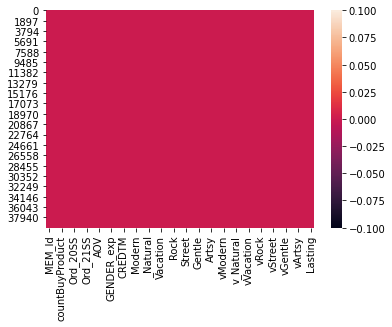

In [ ]:
sns.heatmap(df.isnull())

In [ ]:
df = df.fillna(value = 0)
df.head()

,MEM_Id,Otimes,countBuyProduct,countViewProduct,Ord_20SS,Ord_20AW,Ord_21SS,Ttl_Ord,AOV,Lasting,GENDER_adj,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy
0,c896e578c8bcf05212cc33c24f35335cdb26f496,36.0,27.0,31.0,0.0,0.0,36.0,126131.0,3504.0,203,1,0.000000,0.020833,0.090278,0.083333,0.000000,0.000000,0.006944,0.000000,0.354167,0.375000,0.020833,0.020833,0.013889,0.013889
1,abb6cc6a9c4eb90c78f193121cc338b923fd4817,18.0,22.0,38.0,0.0,10.0,8.0,72290.0,4016.0,316,0,0.098696,0.009311,0.180633,0.007449,0.100559,0.039106,0.124767,0.033520,0.040968,0.150838,0.009311,0.027933,0.147114,0.029795
2,ace7d660024060d329dd811bb18f99da3ef51cc3,17.0,49.0,139.0,5.0,8.0,4.0,89379.0,5258.0,516,1,0.048969,0.025773,0.181271,0.102234,0.154639,0.043814,0.006014,0.000000,0.154639,0.160653,0.025773,0.004296,0.088488,0.003436
3,a4c5a654af7c505eb892ab6d23eaa688442999cc,17.0,29.0,551.0,3.0,14.0,0.0,45782.0,2693.0,454,0,0.085971,0.052433,0.220595,0.090458,0.021965,0.004487,0.106991,0.004724,0.027870,0.120453,0.052433,0.075106,0.135569,0.000945
4,3983bcad22387772779b3f71f8031b6cedbcff2a,16.0,44.0,453.0,2.0,2.0,12.0,80301.0,5019.0,400,0,0.043651,0.006803,0.403345,0.120181,0.000850,0.010771,0.009637,0.000850,0.001701,0.015023,0.006803,0.162132,0.185091,0.033163


In [ ]:
tastes = ['Elegant','Modern','Minimal',	'_Natural',	'Girly','Vacation'	,'Vintage',	'Rock',	'Outdoor',	'Street',	'Mode',	'Gentle',	'Preppie',	'Artsy']
for taste in tastes:
  df[taste] = df[taste] * 15 + df['v'+taste]

df['sum'] = df[tastes].sum(axis = 1)

In [ ]:
for taste in tastes:
  df[taste] = df[taste] / df['sum']

In [ ]:
profile = ['Otimes',	'countBuyProduct',	'countViewProduct',	'Ord_20SS',	'Ord_20AW',	'Ord_21SS',	'Ttl_Ord',	'AOV','Lasting','GENDER_adj']
columns =  ['MEM_Id'] + profile + tastes
print(columns)

['MEM_Id', 'Otimes', 'countBuyProduct', 'countViewProduct', 'Ord_20SS', 'Ord_20AW', 'Ord_21SS', 'Ttl_Ord', 'AOV', 'Lasting', 'GENDER_adj', 'Elegant', 'Modern', 'Minimal', '_Natural', 'Girly', 'Vacation', 'Vintage', 'Rock', 'Outdoor', 'Street', 'Mode', 'Gentle', 'Preppie', 'Artsy']


In [ ]:
df= df[(df['sum'] > 0) & (df['Otimes'] > 0)]
df = df.loc[:,columns]
df_t = df.loc[:,tastes] #df_fil.loc[:,columns]
df_t.tail()

,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy
10022,0.0,0.0,0.760000,0.080000,0.0,0.0,0.040000,0.0,0.000000,0.040000,0.0,0.04,0.04,0.0
10024,0.0,0.0,0.027778,0.027778,0.0,0.0,0.027778,0.0,0.444444,0.472222,0.0,0.00,0.00,0.0
10025,0.0,0.0,0.966667,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.00,0.0
10027,0.0,0.0,0.484848,0.484848,0.0,0.0,0.000000,0.0,0.015152,0.015152,0.0,0.00,0.00,0.0
10029,0.0,0.0,0.057692,0.000000,0.0,0.0,0.000000,0.0,0.942308,0.000000,0.0,0.00,0.00,0.0


#K-means Clustering 

In [ ]:
from sklearn.cluster import KMeans

clusters = 5

algorithm = KMeans(n_clusters=clusters, random_state=31)

In [ ]:
y_pred = algorithm.fit_predict(df_t)
print(y_pred[:20])

[1 0 0 0 0 0 4 3 0 0 0 0 0 0 0 0 4 0 0 0]


In [ ]:
df['class'] = y_pred
df_add = df.groupby('class').mean()
df_add = df_add.reindex(index = [2,1,3,4,0])
df_add

,Otimes,countBuyProduct,countViewProduct,Ord_20SS,Ord_20AW,Ord_21SS,Ttl_Ord,AOV,Lasting,GENDER_adj,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy
class,,,,,,,,,,,,,,,,,,,,,,,,
2,1.222437,2.248549,13.418762,0.198259,0.221470,0.802708,2323.352998,1864.581238,159.620890,0.606383,0.030238,0.003370,0.834336,0.049362,0.006922,0.008977,0.011502,0.001260,0.010384,0.022084,0.003370,0.004085,0.011312,0.002798
1,1.173184,1.817505,6.318436,0.090317,0.554004,0.528864,2462.366853,1966.972067,170.719739,0.499069,0.007879,0.026863,0.029143,0.012430,0.004883,0.005423,0.018714,0.000898,0.422062,0.418632,0.026863,0.011347,0.012241,0.002623
3,1.320856,1.871123,14.804813,0.209091,0.673797,0.437968,3734.645989,2722.498930,215.883422,0.268449,0.017410,0.005185,0.046430,0.018437,0.008629,0.009599,0.299743,0.001813,0.017813,0.289652,0.005185,0.007201,0.270004,0.002900
4,1.543220,3.102542,27.872881,0.271186,0.844915,0.427119,4465.049153,2680.368644,237.327119,0.940678,0.062161,0.017385,0.056636,0.042136,0.308804,0.055182,0.029947,0.060989,0.024988,0.284669,0.017385,0.003024,0.024983,0.011711
0,1.645929,3.119266,43.453268,0.214736,0.766342,0.664851,5050.643922,2918.471904,209.178039,0.700115,0.161975,0.041576,0.274736,0.152018,0.043298,0.065047,0.046718,0.006557,0.031871,0.068332,0.041576,0.017683,0.035610,0.013003


In [ ]:
df_cluster = df_t.groupby(y_pred).mean()
#df_cluster = df_cluster.reset_index()
df_cluster.index = df_cluster.index.map({0:'Rainbow',1:'StreetOutdoor',2:'Minimalist',3:'VintagePreppie',4:'GirlyStreet'})
#df_cluster.set_index(['Rainbow','StreetOutdoor','Minimalist','VintagePreppie','GirlyStreet'])
#df_cluster = df_cluster.drop('index', axis=1)
df_cluster = df_cluster.reindex(index = ['Minimalist','StreetOutdoor','VintagePreppie','GirlyStreet','Rainbow'])
df_cluster

,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy
Minimalist,0.030238,0.003370,0.834336,0.049362,0.006922,0.008977,0.011502,0.001260,0.010384,0.022084,0.003370,0.004085,0.011312,0.002798
StreetOutdoor,0.007879,0.026863,0.029143,0.012430,0.004883,0.005423,0.018714,0.000898,0.422062,0.418632,0.026863,0.011347,0.012241,0.002623
VintagePreppie,0.017410,0.005185,0.046430,0.018437,0.008629,0.009599,0.299743,0.001813,0.017813,0.289652,0.005185,0.007201,0.270004,0.002900
GirlyStreet,0.062161,0.017385,0.056636,0.042136,0.308804,0.055182,0.029947,0.060989,0.024988,0.284669,0.017385,0.003024,0.024983,0.011711
Rainbow,0.161975,0.041576,0.274736,0.152018,0.043298,0.065047,0.046718,0.006557,0.031871,0.068332,0.041576,0.017683,0.035610,0.013003


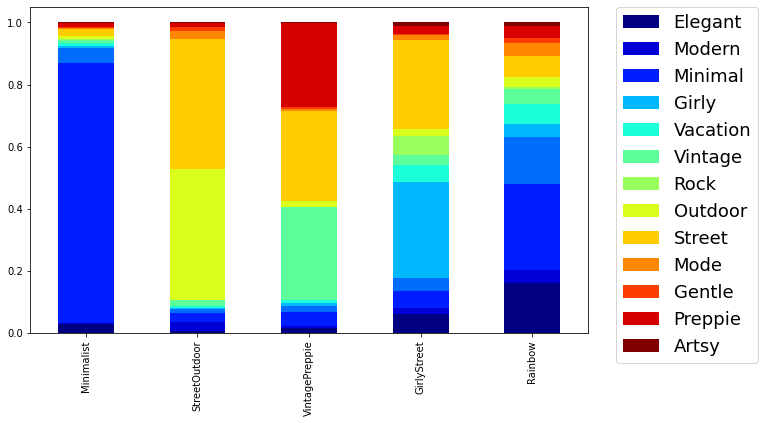

In [ ]:
df_cluster.plot(kind = 'bar', stacked =True, figsize=(10,6),colormap='jet',)
#sns.barplot(data = df_cluster, order = 'Minimal' ,estimator=sum)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

#Insight
#好むテイストが偏れば偏るほど、合計オーダー金額やAOVが下がる。
#逆に好みが多様化なユーザーほど、オーダー回数、平均単価は上がる(ここの因果関係は注意が必要。相関はあれど因果かどうかはわからない)
#虹色の0番(サイトの構成比と同じ男女比)
#Street、Girlyをメインに色んなテイストをちょい載せする4番(94%が女性)
#フレッドペリーのファン中心の3番(ほぼ男性)
#Street、Outdoorの2色メインの1番
#Minimalのみの2番

In [ ]:
 df[df['class'] == 0] #3727のクラス3の人々。。。彼らは総じて高いパフォーマンスを出している

,MEM_Id,Otimes,countBuyProduct,countViewProduct,Ord_20SS,Ord_20AW,Ord_21SS,Ttl_Ord,AOV,Lasting,GENDER_adj,Elegant,Modern,Minimal,_Natural,Girly,Vacation,Vintage,Rock,Outdoor,Street,Mode,Gentle,Preppie,Artsy,class
4,3983bcad22387772779b3f71f8031b6cedbcff2a,16.0,44.0,453.0,2.0,2.0,12.0,80301.0,5019.0,400,0,0.043651,0.006803,0.403345,0.120181,0.000850,0.010771,0.009637,0.000850,0.001701,0.015023,0.006803,0.162132,0.185091,0.033163,0
12,28614cc91dfa5aa9d3509d0b8daef14554aa80ec,13.0,22.0,50.0,6.0,3.0,4.0,19999.0,1538.0,395,1,0.164251,0.024155,0.473430,0.101449,0.083736,0.037037,0.001610,0.003221,0.000000,0.037037,0.024155,0.000000,0.001610,0.048309,0
14,26334ebb89e1bb5266d300e3a43726846ee111ea,12.0,22.0,248.0,1.0,9.0,2.0,17102.0,1425.0,330,0,0.079403,0.029874,0.343553,0.062107,0.048742,0.026730,0.050314,0.000000,0.090409,0.142296,0.029874,0.017296,0.077830,0.001572,0
17,492d6c89b6cc044855164fc6d864ad625651fa5d,11.0,23.0,2.0,0.0,10.0,1.0,39741.0,3613.0,282,1,0.113122,0.022624,0.297134,0.182504,0.090498,0.090498,0.045249,0.022624,0.000000,0.090498,0.022624,0.000000,0.000000,0.022624,0
30,0f92c6c65640b629cdf1d65470cc5c75d29abd5a,9.0,23.0,273.0,7.0,2.0,0.0,26787.0,2976.0,489,1,0.229741,0.036759,0.444444,0.100251,0.031746,0.037594,0.017544,0.000835,0.008354,0.025898,0.036759,0.001671,0.005848,0.022556,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10001,000000009252@oau_google,1.0,4.0,54.0,0.0,0.0,1.0,4307.0,4307.0,24,0,0.004878,0.000000,0.551220,0.292683,0.000000,0.000000,0.014634,0.000000,0.039024,0.063415,0.000000,0.009756,0.024390,0.000000,0
10013,c7a801689448f4740a5dd4b8175f04ffb394b2bc,1.0,1.0,37.0,0.0,0.0,1.0,490.0,490.0,36,0,0.037500,0.000000,0.418750,0.300000,0.006250,0.012500,0.087500,0.000000,0.012500,0.100000,0.000000,0.000000,0.025000,0.000000,0
10014,9e7c1fa4b7ab7e47902329643cbf04e366cb6a2b,1.0,2.0,28.0,0.0,0.0,1.0,2090.0,2090.0,36,0,0.027523,0.009174,0.357798,0.091743,0.000000,0.000000,0.018349,0.009174,0.220183,0.229358,0.009174,0.009174,0.009174,0.009174,0
10016,000000007858@oau_google,1.0,4.0,118.0,0.0,0.0,1.0,2694.0,2694.0,57,0,0.101942,0.007282,0.303398,0.114078,0.000000,0.004854,0.199029,0.000000,0.004854,0.196602,0.007282,0.026699,0.021845,0.012136,0


#K-means Clustering By Profile

In [ ]:
df_p = df.loc[:,profile]
df_p.head()

NameError: ignored

In [ ]:
y_pred2 = algorithm.fit_predict(df_p)
y_pred2

NameError: ignored

In [ ]:
df_p_cluster = df_p.groupby(y_pred2).mean()
df_p_cluster

In [ ]:
df_p_cluster.plot(kind = 'bar', stacked =True, figsize=(10,6),colormap='jet')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

In [ ]:
#顧客分析の改善点
#ROGが外れ値になっており、POCO等と同じく取り除く必要あり。>DONE
#年齢の記入がない人が多く、これを活かすには年齢を推測するアルゴリズムが必要かも
#生活用品のブランドにタグが付いておらず、これらを購入した人のブランドタグが蓄積できない>すべてのブランドに付与する必要あり
#ブランドタグシートに不具合、バイイングアイテムが7777とSourceVendorの2つに分かれてしまっていた。>発見したものは修正。
#データベース更新するときのダウンタイムはなんとかならないか？２時間ごとに１０分ほど、数字がおかしくなるのは使いにくい。２時間更新のテーブルに対し冗長性をもたせられないか。

#Old codes

In [ ]:
table = df.loc[(df['RefundStatus'].isnull()) & (df['Transfer Status']=='Trans') &(~df['Coupon.Name'].fillna('no_activity').str.contains('KOL|員工')) & ~(df['Price']==0)]
## 排除退貨, 排員工折扣&KOL, 排除贈品

table['Brand'].value_counts()
print("平均單品價格(沒扣折扣卷): "+str(table['PriceAfterDiscount'].mean()))
print("平均單品價格(扣折扣卷): "+str(table['SkuRowSumAfterDiscount'].mean()))

KeyError: ignored

In [ ]:
srs = table.groupby(by='MemberId')['Ordid'].nunique()
value = srs.value_counts()
value.loc[0] = 13082 

aa = value.sort_index()
aa

0     13082
1      1923
2       299
3       102
4        34
5        17
6        12
7         2
8         2
9         4
12        1
13        1
14        1
19        1
Name: Ordid, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


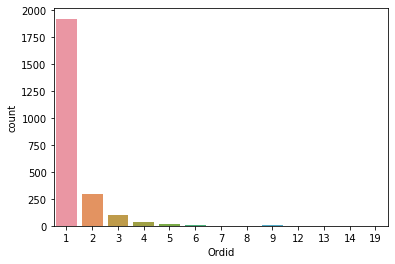

In [ ]:
sns.countplot(srs)

In [ ]:
srs.max()

19

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


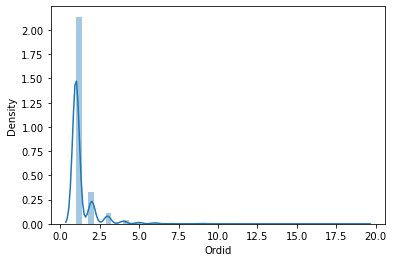

In [ ]:
sns.distplot(srs)

In [ ]:
srs.mean()

1.3522300958732805

In [ ]:
table['Ordid'].nunique()

3244

In [ ]:
table['MemberId'].nunique()

2399

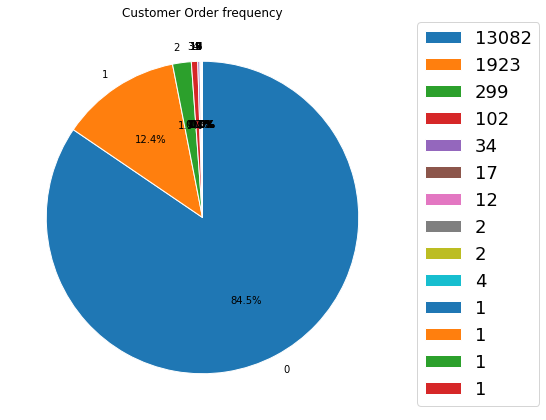

In [ ]:
plt.figure(figsize=(7,14))

plt.pie(aa, labels =aa.index,autopct="%.1f%%",counterclock=False, startangle=90, wedgeprops={'linewidth': 1, 'edgecolor':"white"})
plt.title('Customer Order frequency')
plt.legend(aa,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

In [ ]:
srs = table.groupby(by='MemberId')['Ordid'].nunique()
srs

MemberId
000000000060@oau_apple                      1
000000000071@oau_apple                      2
000000000077@oau_apple                      1
000000000078@oau_apple                      1
000000000091@oau_apple                      1
                                           ..
ffabf9ff9c6dbde2b41f9d7fe2c01ada5410aeee    1
ffb31935968807264122f44f1d59db5018e87755    1
ffcbb7c7d863b1b12326a90e0103c6da484862af    6
ffdc75aa509cdf439cf56290a28c83a58abce3ee    1
fff8a0e665b45e633113c94c33bbf2b6fa49506f    1
Name: Ordid, Length: 2399, dtype: int64

In [ ]:
table.groupby(by='MemberId')['Ordid'].nunique()

MemberId
000000000060@oau_apple                      1
000000000071@oau_apple                      2
000000000077@oau_apple                      1
000000000078@oau_apple                      1
000000000091@oau_apple                      1
                                           ..
ffabf9ff9c6dbde2b41f9d7fe2c01ada5410aeee    1
ffb31935968807264122f44f1d59db5018e87755    1
ffcbb7c7d863b1b12326a90e0103c6da484862af    6
ffdc75aa509cdf439cf56290a28c83a58abce3ee    1
fff8a0e665b45e633113c94c33bbf2b6fa49506f    1
Name: Ordid, Length: 2399, dtype: int64

In [ ]:
onetime = srs[srs==1]
table.dtypes

UniqueId                          object
Ordid                             object
No                                 int64
RefundStatus                      object
ProdId                            object
ProdName                          object
Spec                              object
VendorId                          object
ShipDate                          object
ShipId                           float64
ShipVendorId                     float64
Price                              int64
Qty                                int64
Activity.Id                       object
Activity.Name                     object
Activity.Type                    float64
Activity.Discount                float64
Coupon.Id                         object
Coupon.Name                       object
Coupon.Discount                  float64
SpecialPrice.Id                   object
SpecialPrice.Discount            float64
SkuRowSum                         object
SkuRowSumAfterDiscount             int64
OrderDate       

In [ ]:
table[table.MemberId.isin(onetime.index)] ##只買過1次的客人
one_time_customer = table[table.MemberId.isin(onetime.index)]
Latest1c = one_time_customer[one_time_customer.OrderDate > dt.datetime(2020,8,1) ]
Latest1c['Ordid'].nunique()

1369

In [ ]:
table[table.MemberId.isin(onetime.index)] ##只買過1次的客人
one_time_customer = table[table.MemberId.isin(onetime.index)]
Latest1c = one_time_customer[one_time_customer.OrderDate > dt.datetime(2020,9,1) ]
Latest1c['Ordid'].nunique()

990

In [ ]:
table[table.MemberId.isin(onetime.index)] ##只買過1次的客人
one_time_customer = table[table.MemberId.isin(onetime.index)]
Latest1c = one_time_customer[one_time_customer.OrderDate > dt.datetime(2020,10,1) ]
Latest1c['Ordid'].nunique()

737

In [ ]:
table[table.MemberId.isin(onetime.index)] ##只買過1次的客人
one_time_customer = table[table.MemberId.isin(onetime.index)]
Latest1c = one_time_customer[one_time_customer.OrderDate > dt.datetime(2020,11,1) ]
Latest1c['Ordid'].nunique()

544